In [38]:
from datasets import load_dataset
import pandas as pd

from sklearn import set_config
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import  Pipeline

from IPython.display import display
import matplotlib.pyplot as plt


In [39]:
dataset = load_dataset("csv", data_files="./spotify-tracks-dataset/dataset.csv")

df = pd.DataFrame(dataset['train'])

display(df.head())

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Data Preprocessing

Remove Null values from the dataset

In [40]:
rows_with_null = df[df.isnull().any(axis=1)]
display(rows_with_null)

fill_values = {'artists': "Unknown", 'album_name': 'Unknown', 'track_name': 'Unknown'}
df = df.fillna(fill_values)

rows_with_null = df[df.isnull().any(axis=1)]
display(rows_with_null)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,None,None,None,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre


# Numerical Features

First, we will look at the numerical features and their distributions. We will apply a StandardScaler to the numerical features which will transform the data to have a mean of zero and a standard deviation of one.

In [41]:
numerical_features = ['popularity', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 
                        'acousticness', 'instrumentalness', 'liveness', 'valence']

numerical_transformer = StandardScaler()
numerical_data_transformed = numerical_transformer.fit_transform(df[numerical_features])

print("Numerical Data Tranformed Shape: ", numerical_data_transformed.shape)
# Sprint(numerical_data_transformed)

Numerical Data Tranformed Shape:  (114000, 10)


# Categorical Features

Next, we will look at the categorical features. We will apply a OneHotEncoder to the categorical features which will transform the data to a binary vector.

In [42]:
categorical_features = ['track_genre']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_data_transformed = categorical_transformer.fit_transform(df[categorical_features])


print("Categorical Data Transformed Shape:", categorical_data_transformed.shape)
    
# print(categorical_data_transformed)

Categorical Data Transformed Shape: (114000, 114)


# Text Features

Now it's getting interesting

In [43]:
text_features = ['artists', 'album_name', 'track_name']

# Convert all text features to a single string
df['combined_text'] = df[text_features].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

text_transformer = TfidfVectorizer()
text_features_transformed = text_transformer.fit_transform(df['combined_text'])

print("Text Features Transformed Shape:", text_features_transformed.shape)
# print(text_features_transformed)


Text Features Transformed Shape: (114000, 78057)


# Pipelines

Let's have a look at the pipelines we will use to transform the data. We will create a pipeline for each feature type.

In [44]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))
])

text_pipeline = Pipeline(steps=[
    ('tfidf',TfidfVectorizer())   
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,numerical_features),
    ('cat_pipeline',cat_pipeline,categorical_features),
    ('text_pipeline',text_pipeline,text_features)
    ],
    remainder='drop',
    n_jobs=-1)

clf = LogisticRegression(random_state=0)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])

set_config(display='diagram')
display(clf_pipeline)


Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['popularity', 'danceability',
                                                   'energy', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['track_genre']),
                                                 ('text_pipeline',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  ['artists', 'album_name',
                                                   'track_name'])])),
                ('model', LogisticRegression(random_state=0))])

# Search Function

In [45]:
def search_tracks(query, df, columns=['artists', 'album_name', 'track_name']):
    # Combine the relevant columns into a single text
    df['combined'] = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

    # Using TF-IDF Vectorizer to convert text data to vectors
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['combined'])

    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get the index of the track that matches the query
    idx = df.index[df['combined'].str.contains(query, case=False)].tolist()

    # Get the pairwsie similarity scores of all tracks with the query track
    sim_scores = list(enumerate(cosine_sim[idx[0]]))

    # Sort the tracks based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar tracks
    sim_scores = sim_scores[1:11]

    # Get the track indices
    track_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar tracks
    return df[columns].iloc[track_indices]

# Example usage
query = "Can't Help Falling In Love"
search_results = search_tracks(query, df)
display(search_results)

,artists,album_name,track_name
279,Kina Grannis,Can't Help Falling In Love (Piano Version),Can't Help Falling In Love - Piano Version
533,Kina Grannis,The Living Room Sessions Vol. 3,Can't Help Falling In Love
313,Kina Grannis,In the Waiting,For Now
351,Aqualung;Kina Grannis,10 Futures,To the Wonder (feat. Kina Grannis)
79550,Aqualung;Kina Grannis,10 Futures,To the Wonder (feat. Kina Grannis)
654,Kina Grannis,When the Party's Over,When the Party's Over
354,Kina Grannis,Oh What A Love,Oh What A Love
94052,Kina,U’re Mine,U’re Mine
809,Kina Grannis,Beyond The Sea,Beyond The Sea
117,Kina Grannis,You Are My Sunshine,You Are My Sunshine


# Recommendation Function

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Selecting features for the recommendation
features = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = df[features]

# Normalizing the feature vectors
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to get index from track name
def get_index_from_track_name(track_name):
    result = df[df.track_name == track_name].index
    if not result.empty:
        print("Found this matching track:")
        display(df.iloc[result].head(1))
        return result[0]
    else:
        return None

# Recommendation function
def recommend_tracks(track_name, num_recommendations=10):
    track_index = get_index_from_track_name(track_name)
    if track_index is None:
        return "Track not found"

    # Compute the cosine similarity for the specified track
    cosine_sim = cosine_similarity([X_scaled[track_index]], X_scaled)[0]

    # Get the top N similar tracks
    sim_scores_indices = cosine_sim.argsort()[-num_recommendations-1:-1][::-1]
    
    # make a copy of the dataframe and append the similarity scores
    df_copy = df.copy()
    df_copy['similarity_score'] = cosine_sim
    
    # Return the top N similar tracks
    return df_copy.iloc[sim_scores_indices]

# Example usage
track_name = "Can't Help Falling In Love"
recommended_tracks = recommend_tracks(track_name)
print("Recommended Tracks:")
display(recommended_tracks)

Found this matching track:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,combined_text,combined
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,0.0363,0.905,0.000071,0.132,0.143,181.74,3,acoustic,Kina Grannis Crazy Rich Asians (Original Motio...,Kina Grannis Crazy Rich Asians (Original Motio...


Recommended Tracks:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,combined_text,combined,similarity_score
93779,93779,5pZKRP7OHyKRog7qI7esqF,Ivan Kozlovsky,Songs of Old Russia / Popular Russian Music Fr...,Ozhidanyie - Zachem Sidish Polunchi,3,198706,False,0.272,0.0616,...,0.989,0.000020,0.1180,0.1190,168.525,3,romance,Ivan Kozlovsky Songs of Old Russia / Popular R...,Ivan Kozlovsky Songs of Old Russia / Popular R...,0.997279
279,279,24UxG3p1Ghtc5ejJtGBoeL,Kina Grannis,Can't Help Falling In Love (Piano Version),Can't Help Falling In Love - Piano Version,54,211624,False,0.271,0.0937,...,0.939,0.000000,0.1080,0.1470,164.721,5,acoustic,Kina Grannis Can't Help Falling In Love (Piano...,Kina Grannis Can't Help Falling In Love (Piano...,0.996838
93946,93946,1xmIv8Z48sOB7g0zbzjrwv,Sergei Lemeshev,Russian Vocal School: Sergey Lemeshev (1939-1965),Ne osennij melkij dozhdichek (It's Not Autumna...,0,198813,False,0.290,0.1150,...,0.979,0.000000,0.0802,0.0969,167.171,3,romance,Sergei Lemeshev Russian Vocal School: Sergey L...,Sergei Lemeshev Russian Vocal School: Sergey L...,0.995018
12178,12178,1Juu6Lvbf5ByIghY6uDbM0,林姍姍;David Ling Jr,我愛經典系列,把歌談心,27,343000,False,0.304,0.1240,...,0.948,0.001040,0.1430,0.0828,168.996,4,cantopop,林姍姍;David Ling Jr 我愛經典系列 把歌談心,林姍姍;David Ling Jr 我愛經典系列 把歌談心,0.994032
76431,76431,1402Qi415TaUB0XXXqpyls,Collabro,Home (Deluxe),"Empty Chairs at Empty Tables (From ""Les Misera...",22,183293,False,0.264,0.1300,...,0.891,0.000000,0.1050,0.0899,172.034,4,opera,Collabro Home (Deluxe) Empty Chairs at Empty T...,Collabro Home (Deluxe) Empty Chairs at Empty T...,0.993842
64083,64083,1NAvb7rxR26xGIC9jthaEu,Norah Jones,Un tecito y a mimir,The Nearness Of You,0,189906,False,0.388,0.0378,...,0.979,0.000210,0.0947,0.2050,166.882,3,jazz,Norah Jones Un tecito y a mimir The Nearness O...,Norah Jones Un tecito y a mimir The Nearness O...,0.992946
62074,62074,1NAvb7rxR26xGIC9jthaEu,Norah Jones,Un tecito y a mimir,The Nearness Of You,0,189906,False,0.388,0.0378,...,0.979,0.000210,0.0947,0.2050,166.882,3,j-pop,Norah Jones Un tecito y a mimir The Nearness O...,Norah Jones Un tecito y a mimir The Nearness O...,0.992946
108281,108281,25NuGWk6dbNy8Eyt6zNlsR,Maria Graña;Mercedes Sosa,María,Naranjo en Flor (feat. Mercedes Sosa),22,225800,False,0.380,0.0695,...,0.973,0.000001,0.1120,0.0709,168.362,4,tango,Maria Graña;Mercedes Sosa María Naranjo en Flo...,Maria Graña;Mercedes Sosa María Naranjo en Flo...,0.992657
93673,93673,0e9pDxoOOkDQijevdS6krs,Vadim Kozin,Вадим Козин. 20 лучших песен,Последний раз,0,182813,False,0.307,0.0272,...,0.991,0.003350,0.0592,0.0720,172.324,4,romance,Vadim Kozin Вадим Козин. 20 лучших песен После...,Vadim Kozin Вадим Козин. 20 лучших песен После...,0.992172
26213,26213,11g9GgpchfORJxVEYFFDoL,Kristen Bell;Agatha Lee Monn;Katie Lopez,Frozen (Original Motion Picture Soundtrack),"Do You Want to Build a Snowman? - From ""Frozen...",50,206506,False,0.306,0.1210,...,0.850,0.000176,0.2570,0.1660,174.055,4,disney,Kristen Bell;Agatha Lee Monn;Katie Lopez Froze...,Kristen Bell;Agatha Lee Monn;Katie Lopez Froze...,0.992103


# Clustering

In [47]:
scale_columns = ['danceability', 'energy']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[scale_columns])

# K-Means Clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(scaled_data)

# Adding cluster information to the dataset
clustered_data = pd.DataFrame(df, columns=['danceability', 'energy', 'track_name', 'artists'])
clustered_data['Cluster'] = clusters

cluster_1 = clustered_data[clustered_data['Cluster'] == 1]
cluster_1 = cluster_1.sort_values(by=['energy', 'danceability'], ascending=False)
# these are the top 10 high energy danceable tracks
display(cluster_1.head(10))

cluster_0 = clustered_data[clustered_data['Cluster'] == 0]
cluster_0 = cluster_0.sort_values(by=['energy', 'danceability'], ascending=True)
# these are the tracks with the lowest energy and danceability
display(cluster_0.head(10))


,danceability,energy,track_name,artists,Cluster
25937,0.693,1.000,Da sprach der alte Häuptling der Indianer,Willi Herren,1
78481,0.693,1.000,Da sprach der alte Häuptling der Indianer,Willi Herren,1
78558,0.660,1.000,Licht am Fahrrad,Mike Der Bademeister;Schwalmrebellen,1
78409,0.834,0.999,Von hinten Blondine (von vorne Ruine),BB Jürgen,1
25490,0.812,0.999,Ra Ta Ta 2011,Mallorca Cowboys,1
78267,0.812,0.999,Ra Ta Ta 2011,Mallorca Cowboys,1
78591,0.759,0.999,Heute fährt die 18 bis zum Après Ski,Klaus & Klaus;Jürgen Milski,1
78536,0.734,0.999,Finger im Po Mexiko - Single Version,Mickie Krause,1
49333,0.731,0.999,Heartbreak,Francesco Zeta,1
13500,0.730,0.999,Dik Work (feat. DJ Funk),dj funk;TJR,1


,danceability,energy,track_name,artists,Cluster
101577,0.0,0.000000,Pure White Noise - Loopable with No Fade,Sleep Baby Sleep;Relaxation;White Noise Medita...,0
101797,0.0,0.000019,"White Noise - Loopable, No Fade",White Noise Sleep Sounds;Static White Noise So...,0
101230,0.0,0.000020,Pure Brown Noise,Deep Sleep Brown Noise;Deep Sleep White Noise;...,0
101239,0.0,0.000020,Pure Brown Noise,Deep Sleep Brown Noise;Deep Sleep White Noise;...,0
101265,0.0,0.000020,Pure Brown Noise - Loopable with No Fade,Deep Sleep;Relaxation And Meditation;Relax;Ont...,0
101268,0.0,0.000020,Pure Brown Noise - Loopable with no fade,Deep Sleep;Sleep Baby Sleep;Lullabies for Deep...,0
101270,0.0,0.000020,Baby White Noise Series - Pure White Noise,Baby Sweet Dream,0
101335,0.0,0.000020,Pure White Noise,Baby Sweet Dream,0
101377,0.0,0.000020,Pure Brown Noise - Loopable with no fade,Deep Sleep;Sleep Baby Sleep;Lullabies for Deep...,0
101513,0.0,0.000020,Pure Brown Noise - Loopable with No Fade,Deep Sleep;Relaxation And Meditation;Relax;Ont...,0


# Visualization

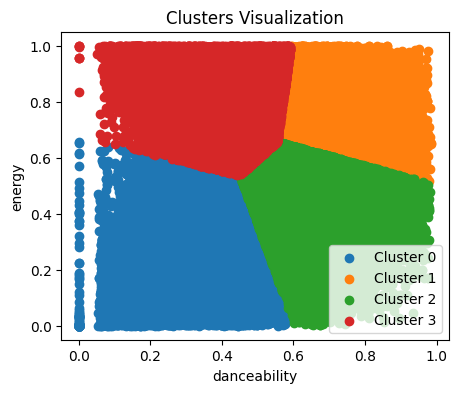

In [48]:
plt.figure(figsize=(5, 4))
for i in range(k):
    cluster = clustered_data[clustered_data['Cluster'] == i]
    plt.scatter(cluster['danceability'], cluster['energy'], label=f'Cluster {i}')
plt.title('Clusters Visualization')
plt.xlabel('danceability')
plt.ylabel('energy')
plt.legend()
plt.show()